In [1]:
import torch
import matplotlib.pyplot as plt

from diffusers.models import AutoencoderKL

import sys
sys.path.append('../src')
from models import *
import utils as utils
from torchvision.utils import make_grid

utils.seed_everything(0, cudnn_deterministic=False)

autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256
)
autoenc.load_state_dict(torch.load('../train_logs/models/sd_image_var_autoenc.pth'))
autoenc.requires_grad_(False)
autoenc.eval()
pass

Note: not using cudnn.deterministic


In [2]:
voxel2sd = Voxel2StableDiffusionModel(use_cont=True)
state_dict = torch.load('../train_logs/models/autoencoder/test/epoch010.pth', map_location='cpu')["model_state_dict"]
for key in list(state_dict.keys()):
    if 'module.' in key:
        state_dict[key.replace('module.', '')] = state_dict[key]
        del state_dict[key]
voxel2sd.load_state_dict(state_dict)
voxel2sd.eval()
pass

In [3]:
# data_commit = '9947586218b6b7c8cab804009ddca5045249a38d'
# train_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_train/train_subj01_{{0..49}}.tar"
# val_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_val/val_subj01_0.tar"
# cache_dir = 'cache'
# n_cache_recs = 0

# train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
#     32, 
#     'images',
#     num_devices=1,
#     num_workers=1,
#     train_url=train_url,
#     val_url=val_url,
#     cache_dir=cache_dir,
#     n_cache_recs=n_cache_recs,
#     voxels_key="nsdgeneral.npy",
# )

subj_id = "01"
train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"

train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    32, 
    'images',
    num_devices=1,
    num_workers=1,
    train_url=train_url,
    val_url=val_url,
    cache_dir=None,
    n_cache_recs=0,
    voxels_key='nsdgeneral.npy',
    val_batch_size=16
)

Getting dataloaders...

num_train 24983
global_batch_size 32
batch_size 32
num_workers 1
num_batches 780
num_worker_batches 780
cache_dir None

num_val 492
val_num_batches 15
val_batch_size 16


In [4]:
val_voxels, val_images, _ = next(iter(val_dl))
trn_voxels, trn_images, _ = next(iter(train_dl))

In [8]:
val_voxels.shape, trn_voxels.shape

(torch.Size([16, 3, 15724]), torch.Size([32, 3, 15724]))

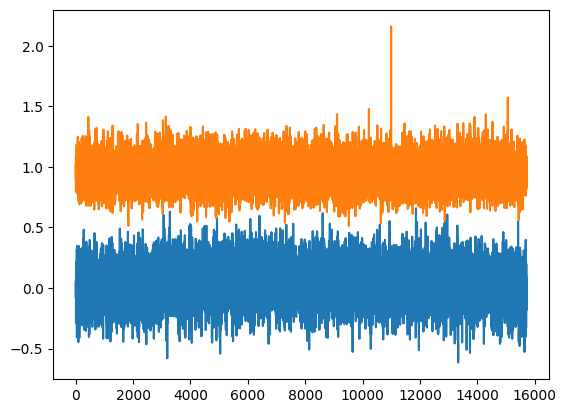

In [6]:
plt.plot(val_voxels.mean(0))
plt.plot(val_voxels.std(0))

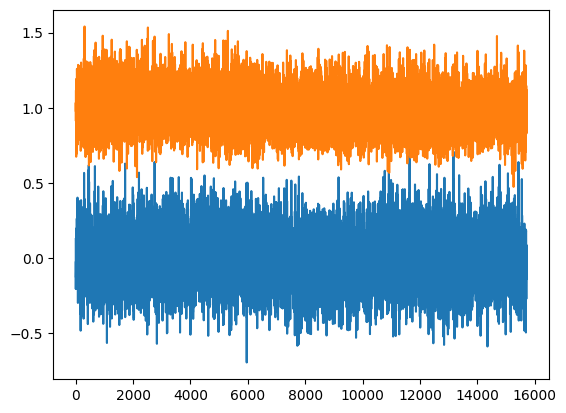

In [7]:
plt.plot(trn_voxels.mean(0))
plt.plot(trn_voxels.std(0))

In [8]:
trn_images.min(), trn_images.max()

(tensor(0.), tensor(1.))

In [9]:
val_images.min(), val_images.max()

(tensor(0.), tensor(1.))

In [29]:
with torch.no_grad():
    preds, tfeats = voxel2sd(trn_voxels[:4][:, 1].float(), return_transformer_feats=True)
    # reconst = autoenc.decode(preds/0.18215).sample

In [37]:
x = trn_voxels[:4][:, 1].float()
with torch.no_grad():
    x = voxel2sd.lin0(x)
    residual = x
    for res_block in voxel2sd.mlp:
        x = res_block(x)
        x = x + residual
        residual = x
    x = x.reshape(len(x), -1)
    x = voxel2sd.lin1(x)  # bs, 4096

    # # x = x.reshape(x.shape[0], -1, 8, 8).contiguous()  # bs, 64, 8, 8
    # x = x.reshape(x.shape[0], -1, 64, 64).contiguous()
    # return self.upsampler(x)

    # decoder
    x = voxel2sd.norm(x.reshape(x.shape[0], 32, 512))
    # reconst = autoenc.decode(preds/0.18215).sample

In [40]:
x[0]

tensor([[ 1.2735,  0.0923,  0.1114,  ...,  1.2116, -0.8727,  0.0933],
        [-0.5544,  0.4121, -0.3483,  ...,  0.2509, -1.3773,  0.9644],
        [ 0.3354, -0.9296, -0.5142,  ..., -0.4354, -0.8186,  0.1269],
        ...,
        [-0.3140,  0.4520, -1.4069,  ...,  1.8115, -1.4778,  0.4057],
        [-1.3568,  1.3060,  0.3842,  ..., -0.3591, -1.7265, -0.7020],
        [-1.2247,  0.3231, -0.2864,  ...,  0.4707, -0.9392,  0.4860]])

In [45]:
voxel2sd.transformer.layers[0]

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
)

In [46]:
with torch.no_grad():
    p0 = voxel2sd.transformer.layers[0](voxel2sd.queries.expand(x.shape[0], -1, -1), x)

In [48]:
p0[0].var(0).mean()

tensor(0.3517)

In [49]:
with torch.no_grad():
    p1 = voxel2sd.transformer.layers[1](p0, x)

In [50]:
p1[0].var(0).mean()

tensor(0.0010)

In [51]:
voxel2sd.transformer.layers[0].linear1.weight

Parameter containing:
tensor([[ 2.8843e-02, -3.9507e-02,  6.1401e-02,  ...,  4.0012e-02,
         -1.1582e-03,  2.6605e-02],
        [-1.6224e-03, -1.1048e-02,  3.9329e-02,  ..., -8.2633e-03,
         -2.7904e-02, -6.3502e-02],
        [ 2.3059e-02,  1.3631e-02, -3.7154e-02,  ..., -1.6264e-02,
         -3.6663e-02, -2.4226e-02],
        ...,
        [ 2.2470e-02,  7.0462e-05,  5.2764e-02,  ...,  4.6970e-02,
         -9.6037e-04,  5.5317e-02],
        [ 1.1158e-02,  1.2602e-02,  5.2733e-02,  ...,  6.8472e-03,
         -2.3580e-02, -2.6532e-02],
        [ 3.7025e-02,  2.0133e-02, -5.9472e-03,  ..., -1.1278e-02,
          7.6034e-03,  3.1239e-02]], requires_grad=True)

In [35]:
tfeats[0].var(0).mean()

tensor(4.1559e-09)

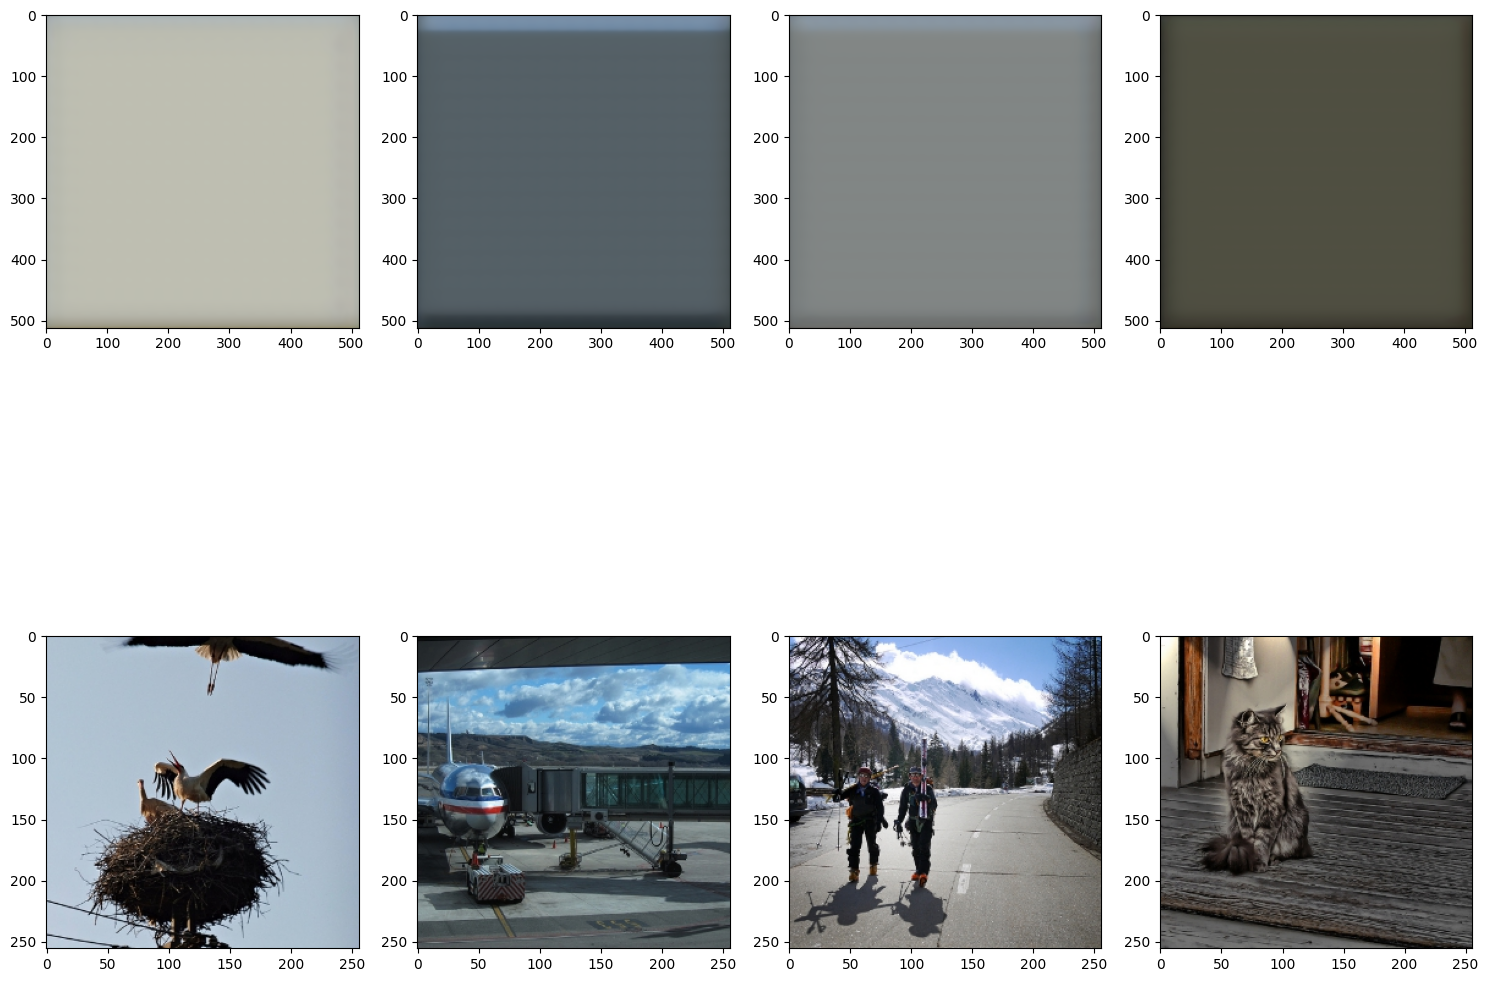

In [9]:
fig, ax = plt.subplots(2,4, figsize=(15,15))
for i in range(4):
    ax[0,i].imshow((reconst[i]/2 + 0.5).permute(1,2,0))
for i in range(4):
    ax[1,i].imshow(trn_images[i].permute(1,2,0))
fig.tight_layout()

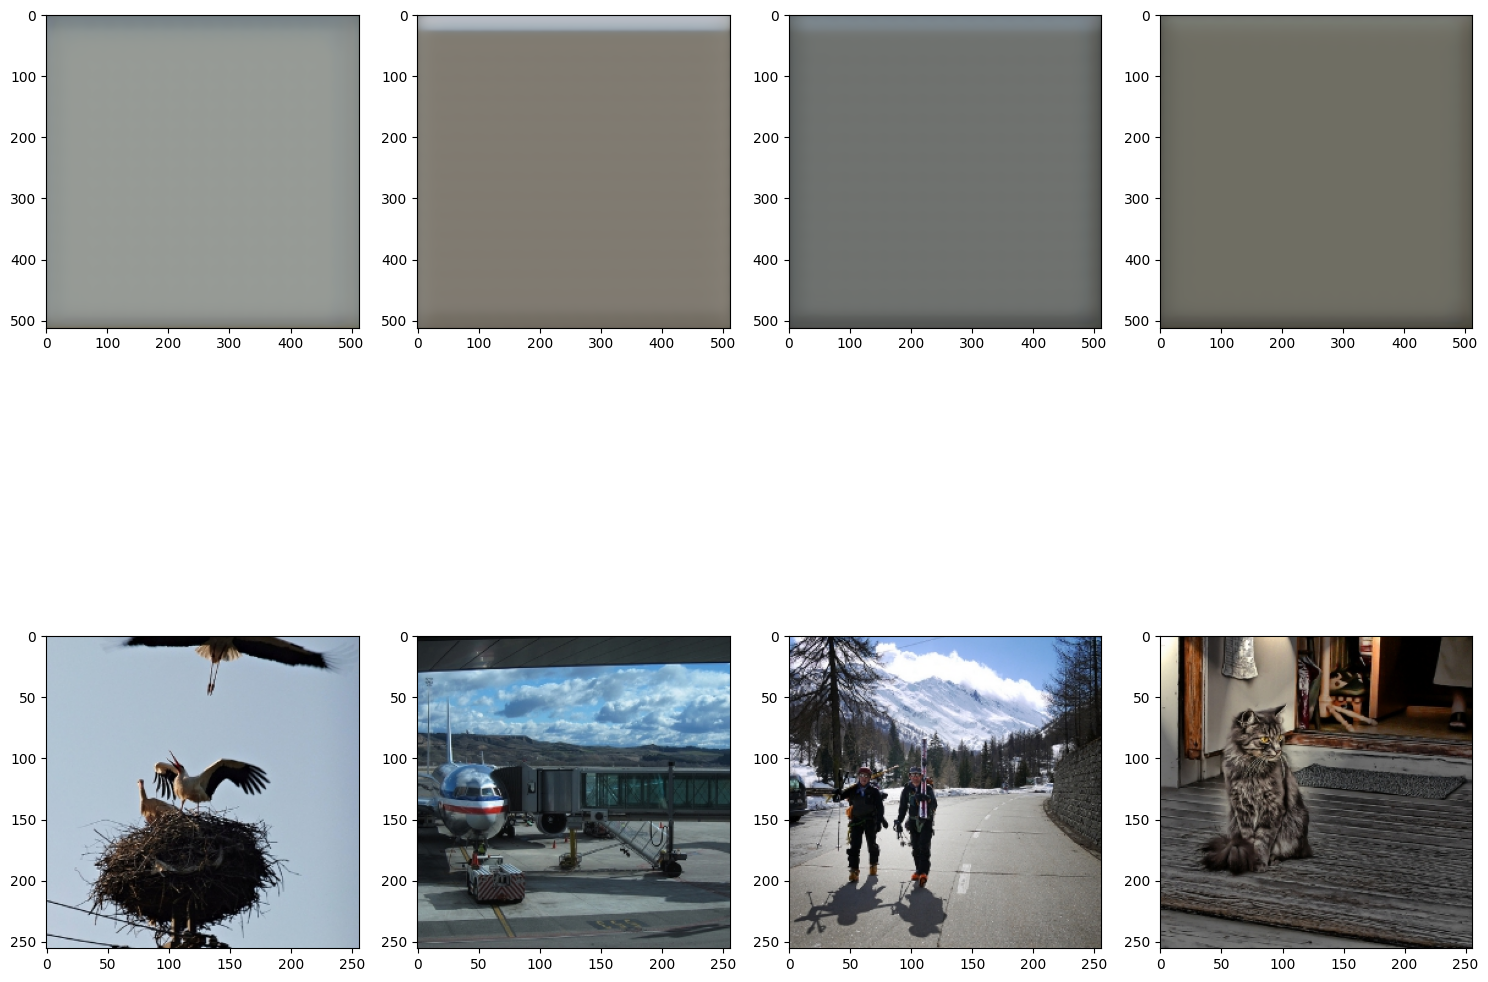

In [23]:
fig, ax = plt.subplots(2,4, figsize=(15,15))
for i in range(4):
    ax[0,i].imshow((reconst[i]/2 + 0.5).permute(1,2,0))
for i in range(4):
    ax[1,i].imshow(trn_images[i].permute(1,2,0))
fig.tight_layout()

In [19]:
voxel2sd.queries

Parameter containing:
tensor([[[-0.2419, -0.9207, -0.0907,  ...,  1.2732,  0.8599, -0.8099],
         [-1.0230,  0.5092,  1.6936,  ..., -1.9984,  0.3827,  0.2383],
         [ 0.5672,  1.3945, -0.8945,  ...,  1.1276, -0.2409, -0.6591],
         ...,
         [-0.6512, -0.2930,  0.3463,  ..., -0.6808,  0.7974, -0.4673],
         [ 0.9812,  0.9528,  0.3190,  ..., -0.5398,  0.5407, -0.0367],
         [-1.1702,  0.0614,  0.5040,  ..., -1.4467, -0.5077, -0.6183]]],
       requires_grad=True)

In [36]:
voxel2sd.queries.shape

torch.Size([1, 256, 512])

In [28]:
voxel2sd.queries.var(1).mean()

tensor(0.9858, grad_fn=<MeanBackward0>)

In [12]:
with torch.no_grad():
    lats = autoenc.encode(2*torch.nn.functional.interpolate(trn_images[:4], (512, 512), mode='bilinear', align_corners=False, antialias=True)-1
                                ).latent_dist.mode().cpu() * 0.18215


In [13]:
F.mse_loss(lats, preds)

tensor(0.7696)

In [18]:
preds[0].var(), lats[0].var()

(tensor(0.2924), tensor(0.8827))

In [5]:
with torch.no_grad():
    preds = voxel2sd(val_voxels[:4].mean(1).float())
    reconst = autoenc.decode(preds/0.18215).sample

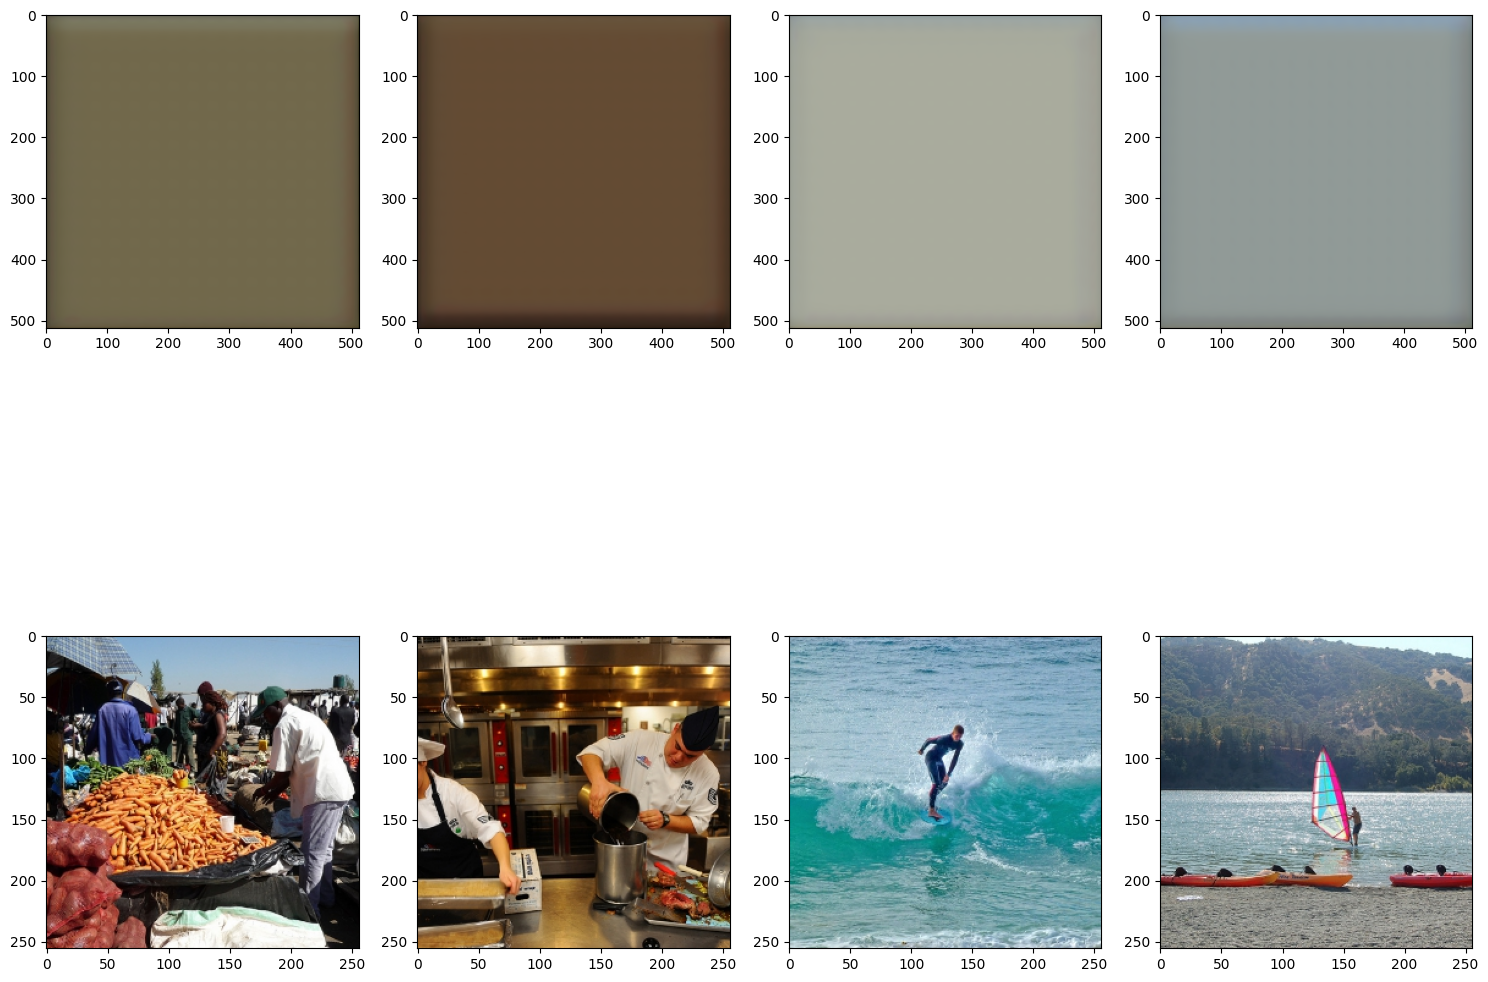

In [6]:
fig, ax = plt.subplots(2,4, figsize=(15,15))
for i in range(4):
    ax[0,i].imshow((reconst[i]/2 + 0.5).permute(1,2,0))
for i in range(4):
    ax[1,i].imshow(val_images[i].permute(1,2,0))
fig.tight_layout()

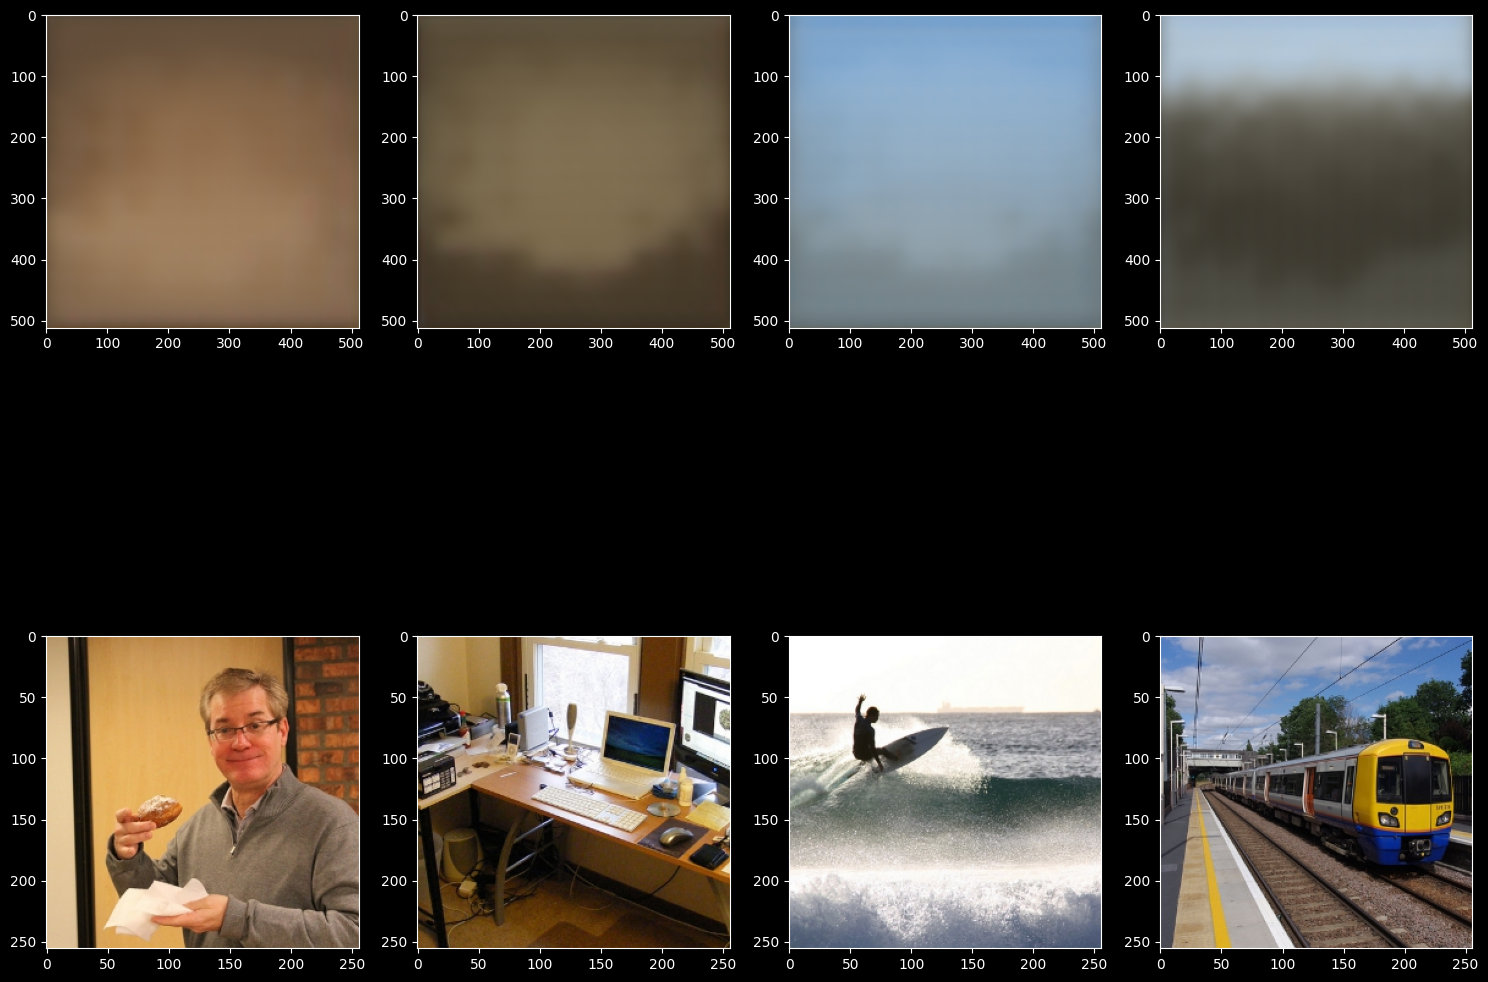

In [12]:
fig, ax = plt.subplots(2,4, figsize=(15,15))
for i in range(4):
    ax[0,i].imshow((reconst[i]/2 + 0.5).permute(1,2,0))
for i in range(4):
    ax[1,i].imshow(val_images[i].permute(1,2,0))
fig.tight_layout()

In [10]:
with torch.no_grad():
    preds = voxel2sd.cuda()(val_voxels.mean(1).float().cuda()).cpu()
    # reconst = autoenc.cuda().decode(preds/0.18215).sample.cpu()
    lats = autoenc.cuda().encode(2*
                                 torch.nn.functional.interpolate(val_images.cuda(), (512, 512), mode='bilinear', align_corners=False, antialias=True)-1
                                ).latent_dist.mode().cpu() * 0.18215

# pred_grid = make_grid(((reconst/2 + 0.5)*255).byte(), nrow=2)
# orig_grid = make_grid((images*255).byte(), nrow=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


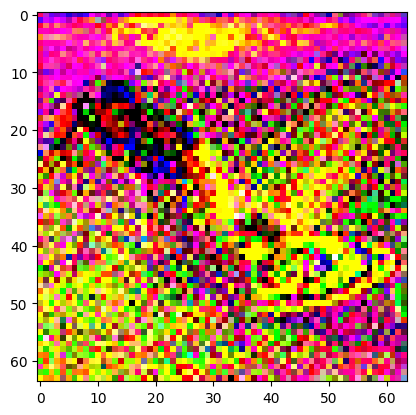

In [11]:
plt.imshow(lats[2].permute(1,2,0)[...,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


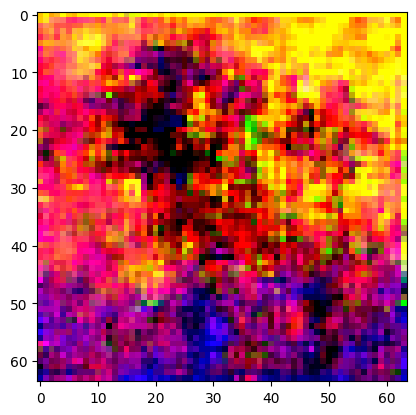

In [12]:
plt.imshow(preds[2].permute(1,2,0)[...,:3])

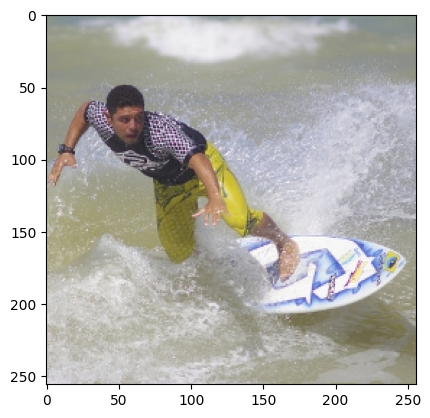

In [13]:
plt.imshow(val_images[2].permute(1,2,0))

In [14]:
with torch.no_grad():
    trn_preds = voxel2sd.cuda()(trn_voxels.float().cuda()).cpu()
    # reconst = autoenc.cuda().decode(preds/0.18215).sample.cpu()
    trn_lats = autoenc.cuda().encode(2*
                                 torch.nn.functional.interpolate(trn_images.cuda(), (512, 512), mode='bilinear', align_corners=False, antialias=True)-1
                                ).latent_dist.mode().cpu() * 0.18215

# pred_grid = make_grid(((reconst/2 + 0.5)*255).byte(), nrow=2)
# orig_grid = make_grid((images*255).byte(), nrow=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


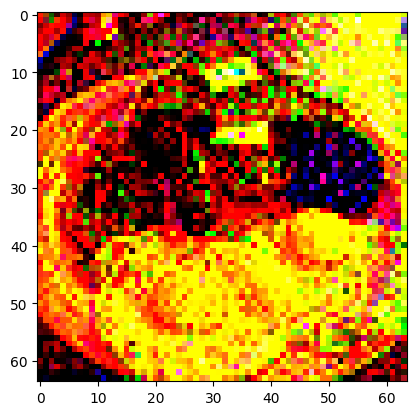

In [22]:
plt.imshow(trn_lats[3].permute(1,2,0)[...,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


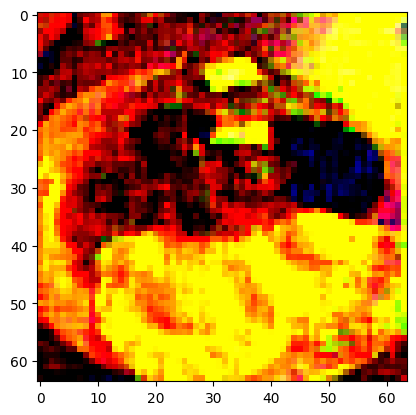

In [21]:
plt.imshow(trn_preds[3].permute(1,2,0)[...,:3])

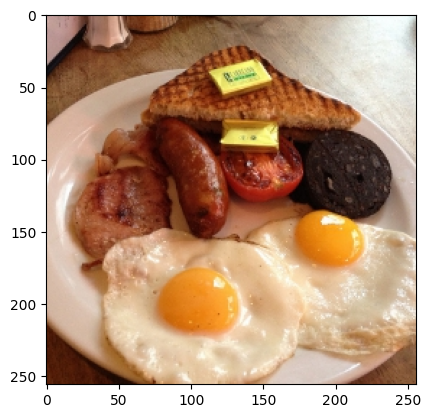

In [20]:
plt.imshow(trn_images[3].permute(1,2,0))

In [4]:
voxels, images, _ = next(iter(val_dl))

In [5]:
with torch.no_grad():
    preds = voxel2sd(voxels.float())
    reconst = autoenc.decode(preds/0.18215).sample

pred_grid = make_grid(((reconst/2 + 0.5)*255).byte(), nrow=2)
orig_grid = make_grid((images*255).byte(), nrow=2)

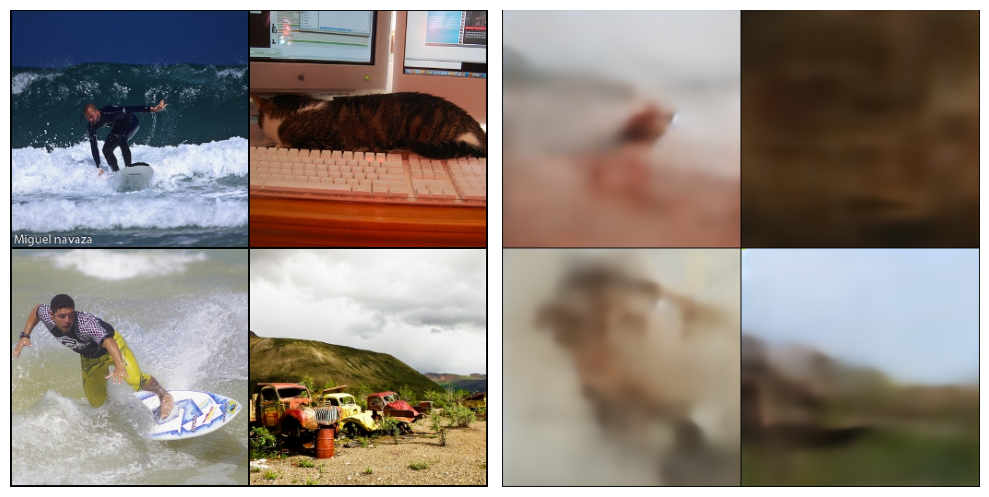

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

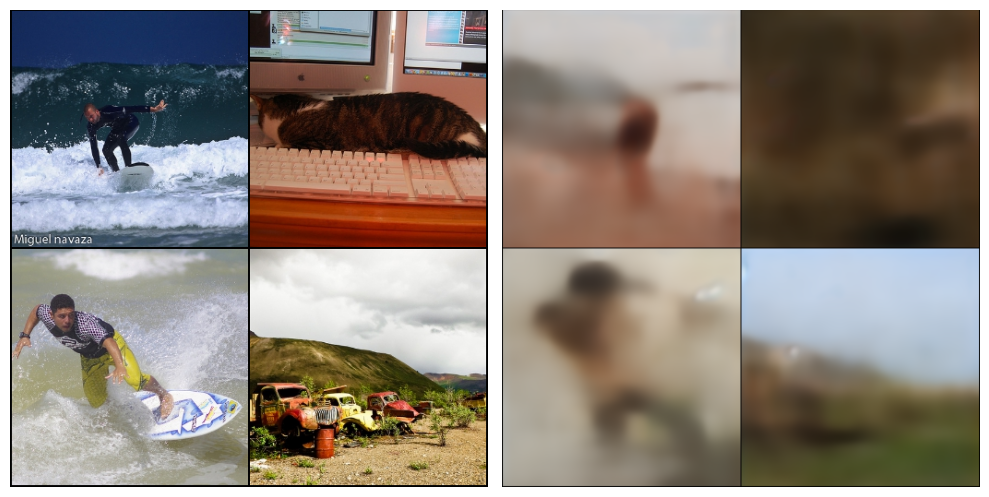

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

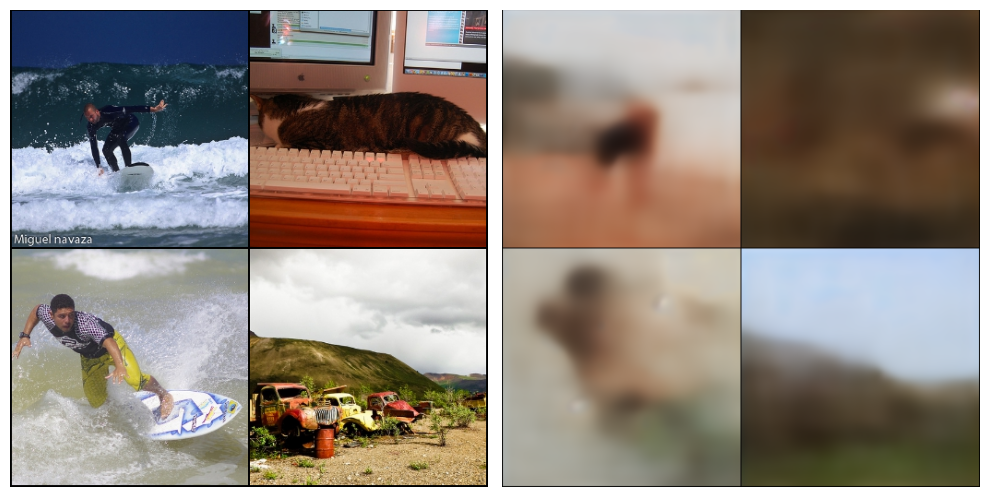

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

In [10]:
images.shape

torch.Size([4, 3, 256, 256])